# Transformer Architecture


In this scenario, you will implement a simple decoder-only Transformer architecture and train the model using the language modeling objective.

# Architecture
This part of the notebook concerns the implementation of the Transformer architecture.
You can read more about transformers in the [original paper](https://arxiv.org/abs/1706.03762).

## Brief Description

### The Input

**Input to the transformer model is a sequence of tokens.   
The length of the input sequence is bounded by model context size.**


**Tokens** can correspond to individual characters, words, or short character sequences.  
Tokens are usually represented as natural numbers.  
The **tokenizer** is a program that converts text to a sequence of tokens.  
For example, consider the word `habitat` if we apply a GPT-3 tokenizer to it, then we will get a sequence of three tokens `[5976, 270, 265]` that corresponds to `["hab", "it", "at"]`.  
The common approach is to tokenize the text using between 30k to 50k different tokens.  
You can read more about tokenizers [here](https://huggingface.co/docs/transformers/tokenizer_summary).


### The Output
For each input token, the transformer model outputs a probability distribution on the next token given the previous tokens in the context.  
For example, if the model inputs three tokens `["hab", "it", "at"]` for the token `it` the model will output probability distribution $\mathbb{P}(t_3 | t_1= hab, t_2=it)$.  
In general if we denote the function induced by the transformer network as $T$ and tokens as $t_i$ for $i\in\{1\dots n\}$, then $T(t_i)=\mathbb{P}(t_i|t_{i-1}\dots t_1)$, where the probability $\mathbb{P}$ is the distribution that the training data was sampled from.




### Transformer Processing Pipeline - Overview
Let's look at the image below.  

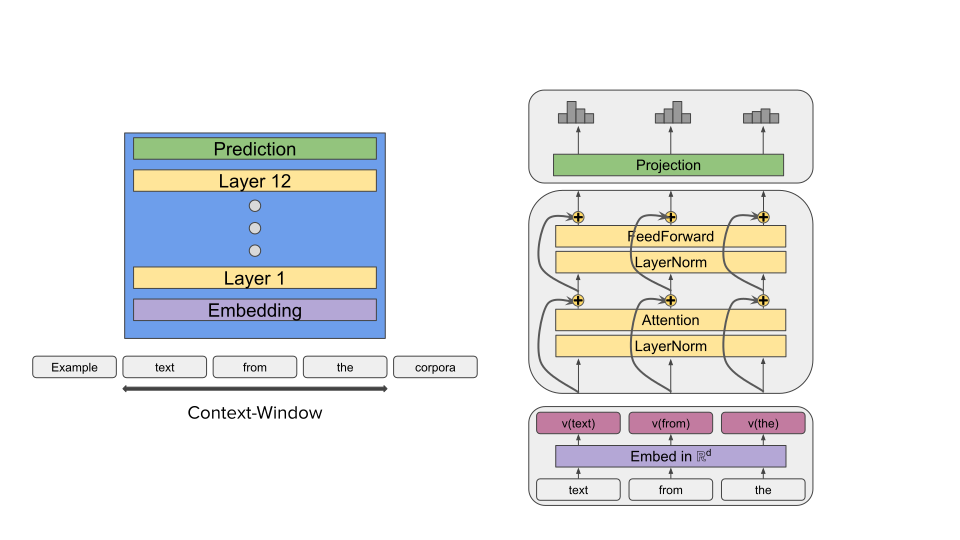



Processing in the Transformer model starts with converting each input token to a vector of real numbers using the Embedding layer.  
The Embedding layer stores a matrix of shape `(num_tokens, hidden_dim)` where each row contains an embedding vector corresponding to a particular token.  
Initially, these vectors are random, but as the model trains it learns to associate `appropriate meaning` with each token.


After the embedding, the tokens (now vectors) are passed through the Transformer layers.
In each layer, two major sublayers are used
* Attention
* FeedForward

Input to those two sublayers is normalized, and a skip connection is applied. This skip connection takes the input to the sublayer before normalization
and adds it to the result of the sublayer.  

Attention allows each token (now represented as a vector) to look at the preceding tokens.
FeedForward is usually implemented as a variant of MLP and allows the model to transform the hidden representation of each token.


After processing, we linearly project each token to a vector of length `num_tokens` and use softmax to generate probability distribution on the next token.

Note that each token (or the corresponding vector) is processed by each layer independently except for the Attention layer, where tokens can "look" at other tokens.

## FeedForward (1p)
Lets start with a simple task to implement the FeedForward layer.  
Follow the docstrings and fill the code below.  

In [3]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
import torch
from typing import List, Tuple, Any, Optional

HiddenT = torch.tensor  # torch tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]


class FeedForward(torch.nn.Module):
    """
    Inputs a tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]
    and processes it as follows:
    * project linearly from hidden_dim to inner_dim
    * apply activation function (GELU)
    * project linearly from inner_dim to hidden_dim
    """

    def __init__(self, hidden_dim: int, inner_dim: int) -> None:
        super().__init__()

        ### YOUR CODE STARTS ###

        #??? this could be wrong (Note that each token (or the corresponding vector)
        # is processed by each layer independently except for the Attention layer, where tokens can "look" at other tokens.)

        self.fc1 = nn.Linear(hidden_dim, inner_dim, bias=False)
        self.fc2 = nn.Linear(inner_dim, hidden_dim, bias=False)

        ###  YOUR CODE ENDS  ###

    def forward(self, x: HiddenT) -> HiddenT:
        # [BATCH, SEQ_LEN, HIDDEN_DIM]
        assert len(x.shape) == 3

        ### YOUR CODE STARTS ###

        x = self.fc1(x)
        x = F.gelu(x)
        result = self.fc2(x)

        ###  YOUR CODE ENDS  ###

        # [BATCH, SEQ_LEN, HIDDEN_DIM]
        assert len(result.shape) == 3
        return result


##### TESTS START #####


def test_ff():
    def test_grad_and_shapes():
        feed_forward = FeedForward(16, 32)
        assert len(list(feed_forward.parameters())) >= 1
        x = torch.rand(3, 5, 16, requires_grad=True)
        y = feed_forward(x)
        assert x.shape == y.shape
        loss = y.sum()
        loss.backward()
        assert x.grad is not None

    test_grad_and_shapes()


test_ff()

#####  TESTS END  #####

## Attention
Let's implement the attention mechanism.
The attention mechanism will allow each token to aggregate information from preceding tokens using a weighted sum.  
Briefly speaking, attention can be described as follows.  
* Preparation:  
    * Use three linear projections (each parametrized by a different matrix) to create three vectors (query, key, value) from each token vector. Each of the vectors should have the length divisible by `num_heads`.
    * Split the created vectors into `num_heads` equal parts. That is we take each query/key/value vector and split it into `num_heads` equal vectors.
    * Apply positional encodings to queries and keys.
* The attention:
    * Calculate how well does each query match each key from the same head.  
    To be more precise, for each head independently calculate the inner product of each query vector with each key vector.   
    That is let Q be the matrix with query vectors as rows and K be the matrix with key vectors as rows.  
    The value needed from this step is $A$, given by $A=QK^T$.
    * Divide the value calculated above by square root of the per-head key dimension
    * Independently for each head convert the computed values into a probability distribution.  
    To be more precise, for the matrix $A$ above calculate row-wise softmax masking out for each query keys that it should not look at (keys that occur after the query in the sequence) - so the matrix $A$ should become lower triangular.
    * Independently for each head, calculate for each token a weighted sum of values.  
    To be more precise for $i$'th token we calculate $O[i] = \sum_{j} A[i, j] V[j]$. So for each input token, the resulting vector is a linear combination of values for other vectors, depending on how 'close' their keys were  to the query.
* The output
    * concatenate outputs of the heads and project them linearly to have the `hidden_dim` dimension


A few notes:
* masking out in softmax should be done so that the softmax values still sum up to ~$1$.
* do not use for loop to loop throughout attention heads

Follow the docstrings and fill in the code below.

### Attention - Create Q,K,V (1p)
Follow the docstrings and fill in the code below.

In [5]:
AttentionT = torch.tensor  # torch tensor of shape [BATCH, SEQ_LEN, NUM_HEADS, HEAD_DIM]


class AttentionCreateQKV(torch.nn.Module):
    """
    Given a tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]
    uses linear projections to create three tensors
    Query, Key and Value.
    Each of the created tensors has shape [BATCH, SEQ_LEN, NUM_HEADS, HEAD_DIM].
    Where HEAD_DIM = HIDDEN_DIM // NUM_HEADS
    """

    def __init__(self, hidden_dim, num_heads) -> None:
        super().__init__()
        assert hidden_dim % num_heads == 0
        self.head_dim = hidden_dim // num_heads
        self.num_heads = num_heads

        ### YOUR CODE STARTS ###

        self.fc_Q = nn.Linear(hidden_dim,hidden_dim, bias=False)
        self.fc_K = nn.Linear(hidden_dim,hidden_dim, bias=False)
        self.fc_V = nn.Linear(hidden_dim,hidden_dim, bias=False)

        ###  YOUR CODE ENDS  ###

    def forward(self, x: HiddenT) -> Tuple[AttentionT, AttentionT, AttentionT]:
        assert len(x.shape) == 3  # torch tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]

        ### YOUR CODE STARTS ###

        Q = self.fc_Q(x)
        Q = torch.stack(torch.chunk(Q,self.num_heads,dim=2),dim=2)

        K = self.fc_K(x)
        K = torch.stack(torch.chunk(K,self.num_heads,dim=2),dim=2)

        V = self.fc_V(x)
        V = torch.stack(torch.chunk(V, self.num_heads,dim=2),dim=2)

        result = (Q, K, V)

        ###  YOUR CODE ENDS  ###

        assert len(result) == 3  # queries, keys, values
        for r in result:
            assert len(r.shape) == 4  # [BATCH, SEQ_LEN, NUM_HEADS, HEAD_DIM]
            assert r.shape[-2:] == (self.num_heads, self.head_dim)
            assert r.shape[:-2] == x.shape[:2]

        return result


##### TESTS START #####


def test_attn_create_qkv():
    def test_shapes():
        hidden_dim = 16
        num_heads = 8
        l = AttentionCreateQKV(hidden_dim=hidden_dim, num_heads=num_heads)
        x = torch.ones(3, 5, hidden_dim)
        ys = l(x)
        assert len(ys) == 3
        for y in ys:
            assert y.shape == x.shape[:-1] + (num_heads, hidden_dim // num_heads)

    test_shapes()


test_attn_create_qkv()

#####  TESTS END  #####

### Attention - Positional Encoding (2p)
A priori, transformer has little information about the relative positions of the tokens.
One of the more modern approaches to positional embeddings is Rotary Positional Embedding (RoPE), which you will implement.
You can read about RoPE [in the original paper](https://arxiv.org/abs/2104.09864) and also [here](https://nn.labml.ai/transformers/rope/index.html) in a more easily digestable form.  

Below is the outline of the idea:
+ let `v_0, ..., v_n` be a sequence of vectors of size `head_dim`, let's assume that `head_dim` is even.
+ for each vector group pack its entries into sets of size 2 (ex. `v_i = v_i.reshape(-1, 2)`)
+ generate a sequence of angles $o_1, ..., o_{\frac{hidden\_dim}{2}}$
+ process `v_i` as follows
    + treat `v_i` as a sequence of vectors of size `2`,
    + rotate `j`'th such vector by angle `i*o_j`

Follow the docstrings and fill in the code below.  
For simplicity you can recompute the angles with each forward pass.  

In [6]:
class RoPEPosEncoding(torch.nn.Module):
    """
    Given a tensor of shape [BATCH, SEQ_LEN, NUM_HEADS, HEAD_DIM]
    applies Rotary Positional Encoding.
    offset allows to apply rotary to sequnce part by part by telling how much tokens preecede the input in the sequence.
    """

    def __init__(self, head_dim, theta) -> None:
        super().__init__()

        assert head_dim % 2 == 0
        self.hidden_dim = head_dim

        ### YOUR CODE STARTS ###
        self.theta = theta

    def forward(self, x: AttentionT, offset: int = 0):
        assert (
            len(x.shape) == 4
        )  # torch tensor of shape [BATCH, SEQ_LEN, NUM_HEADS, HEAD_DIM]
        assert offset >= 0

        ### YOUR CODE STARTS ###

        B,SL,NH,d = x.shape

        #thetas are the same for each head - only m (idx of a token) will change
        #step 2 - there is 2 times less thetas needed than the no. of features in the head, also does multiplication by 2 in the nominator of the exponent
        thetas = 1. / (self.theta ** (torch.arange(0, d, 2).float() / d)).to(x.device)

        #multiply thetas by m (add offset - that many tokens are before the currently processed ones)
        m = torch.arange(x.shape[1], device=x.device, dtype=float) + offset
        # print(torch.reshape(m,(-1,1)))
        thetas = thetas * torch.reshape(m,(-1,1))
        # print(thetas)
        #thetas' shape is [SEQ_LEN, HEAD DIM//2] - for each token, we have one vector with angles its heads will be rotated by

        #to use simpler form of multiplication, each cos and sinus has to be repeated twice, so make each theta appear consecutively two times

        thetas = torch.cat((thetas.flatten()[:,None],thetas.flatten()[:,None]),dim=1).reshape(SL,d)
        # print(thetas)
        cosinuses = thetas.cos()[None,:,None,:]
        sinuses = thetas.sin()[None,:,None,:]

        #create vector similar to Eq (34) from the paper, so that head values can by simply multiplied by sinuses (-x_2,x_1,-x_4,...,-x_d,x_d-1)

        x_1 = -x.reshape(-1,2)[:,1:]
        x_1 = torch.cat((x_1,x.reshape(-1,2)[:,:1]),dim=1).reshape(B,SL,NH,d)

        #now multiply each head from x by cosinuses and each head from x_1 by sinuses (then for a given head we get vector of the same
        # size as that head that consist of concateneted vectors of size 2 that were rotated)

        result = cosinuses*x + sinuses*x_1

        ###  YOUR CODE ENDS  ###
        assert result.shape == x.shape

        return result


##### TESTS START #####


def test_RoPE():
    def test_offset():
        rope = RoPEPosEncoding(16, 10000)
        x = torch.ones(1, 11, 3, 16)
        y = rope(x, offset=0)
        z = rope(x, offset=2)

        assert (torch.abs(z[:, :-2] - y[:, 2:])).sum() <= 1e-4
        assert (torch.abs(z[:, :2] - y[:, :2])).sum() >= 1e-4

    def test_initial_rotation():
        rope = RoPEPosEncoding(16, 10000)
        x = torch.ones(1, 11, 3, 16)
        y = rope(x, offset=0)

        assert (torch.abs(y[:, 0] - x[:, 0])).sum() <= 1e-4

    test_offset()
    test_initial_rotation()


test_RoPE()


#####  TESTS END  #####

### Attention (2p)
It is time to merge the things implemented above into an attention layer.

Follow the docstrings and fill in the code below.

For now you can just set the **cache** variable to **None**, as it isn't utilized in training.

Note that there are tests checking if the returned **cache** is of the correct shape, uncomment them if (hopefully after) you implement it in one of the subsequent exercises.

In [7]:
ACacheT = Tuple[
    torch.tensor, torch.tensor
]  # key, value, both of shape [BATCH, SEQ_LEN, NUM_HEADS, HEAD_DIM]


class Attention(torch.nn.Module):
    """
    Implements multi-head attention layer.
    Inputs tensor x of shape [BATCH, SEQ_LEN, hidden_dim].
    Uses head_proj to create three tensors q, k, v - each of shape
    [BATCH, SEQ_LEN, num_heads, head_dim].
    Then applies RoPE to q and k.
    Then calculates attention within each head, concatenates the results
    and linearly projects them to a tensor of shape [BATCH, SEQ_LEN, hidden_dim].

    Cache is a tuple of keys (kc) and values (vc) calculated in previous calls.
    For training the cache will be empty (tensors kc and vc should have shape [BATCH, 0, num_heads, hidden_dim]),
    For efficient generation, the cache will contain keys (kc), values (vc) of already read/generated tokens
    (this allows the generation of one additional token without recomputing the keys and values for all preceding tokens).
    After RoPE application to k, kc and vc are prepended to k and v respectively.

    The model outputs the linearly projected output of attention along with a cache extended with new keys and values.
    """
    def __init__(
        self, hidden_dim: int, num_heads: int, head_proj=AttentionCreateQKV
    ) -> None:
        super().__init__()

        assert hidden_dim % num_heads == 0

        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads

        ### YOUR CODE STARTS ###
        self.head_proj = head_proj(hidden_dim,num_heads)
        self.fc = nn.Linear(hidden_dim,hidden_dim, bias=False)
        ###  YOUR CODE ENDS  ###

    def get_empty_cache(self, batch_size: int, device) -> ACacheT:
        return torch.empty(
            batch_size, 0, self.num_heads, self.head_dim, device=device
        ), torch.empty(batch_size, 0, self.num_heads, self.head_dim, device=device)

    def forward(self, x: HiddenT, cache: ACacheT) -> HiddenT:
        assert len(x.shape) == 3  # torch tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]

        ### YOUR CODE STARTS ###

        b, s, _ = x.shape

        kc, vc = cache
        cache_seq_len = kc.shape[1]

        Q, K, V = self.head_proj(x)
        rope = RoPEPosEncoding(self.head_dim, 10000)
        # Q = rope(Q)
        # K = rope(K)
        Q = rope(Q, offset=cache_seq_len)
        K = rope(K, offset=cache_seq_len)

        kc = K = torch.cat((kc,K), dim=1)
        vc = V = torch.cat((vc,V), dim=1)

        #get heads together
        Q_org_shape = Q.shape
        Q = torch.transpose(Q, 1, 2)
        K_org_shape = K.shape
        K = torch.transpose(K, 1, 2)
        V = torch.transpose(V, 1, 2)

        #calculate A matrices and scale
        A = torch.matmul(Q,torch.transpose(K,-2,-1))/torch.sqrt(torch.tensor(self.head_dim,device=x.device))
        #now for each batch we have num_heads matrices A of size SEQ_LEN x SEQ_LEN (+ CACHE_SEQ_LEN if cache is used)

        #create mask

        mask = torch.triu(torch.ones(Q_org_shape[-2],Q_org_shape[1],K_org_shape[1], device = x.device),diagonal=cache_seq_len+1).bool()
        A = F.softmax(A.masked_fill(mask, float('-inf')),dim=-1)

        #multiply so that we get output of a size [BATCH, NUM_HEADS, SEQ_LEN, HEAD_DIM, SEQ_LEN]
        #for each batch for each head then for each token we get matrix M consisting of vectors A[i,j]*V[j]
        #each vector is of length HEAD_DIM (and is transposed) and is calculated for each token, so the matrix size is [HEAD_DIM, SEQ_LEN]

        A = A.to(torch.float32)
        O = torch.matmul(A,V)

        #concatenate heads' outputs

        attention = O.transpose(1,2).reshape(b,s,self.hidden_dim).to(torch.float32)
        attention = self.fc(attention)

        cache = (kc,vc)
        attention_weights = A
        ###  YOUR CODE ENDS  ###

        return attention, attention_weights, cache


##### TESTS START #####
def test_attention():
    def test_shapes():
        num_heads = 8
        hidden_dim = 16
        attn_layer = Attention(hidden_dim, num_heads)
        x = torch.ones(2, 5, hidden_dim)
        y, attn_w, _ = attn_layer(
            x, attn_layer.get_empty_cache(2, torch.device("cpu"))
        )

        assert y.shape == x.shape

        assert attn_w.shape == y.shape[:-2] + (num_heads, y.shape[-2], y.shape[-2])

    def test_shapes_cache():
        num_heads = 8
        hidden_dim = 16
        attn_layer = Attention(hidden_dim, num_heads)
        x = torch.ones(2, 5, hidden_dim)
        cache = torch.ones(2, 3, num_heads, hidden_dim // num_heads), torch.ones(
            2, 3, num_heads, hidden_dim // num_heads
        )
        y, attn_w, cache = attn_layer(x, cache)

        assert y.shape == x.shape
        assert len(cache) == 2
        assert cache[0].shape == y.shape[:-2] + (
            8,
            num_heads,
            hidden_dim // num_heads,
        )
        assert cache[0].shape == cache[1].shape
        assert attn_w.shape == y.shape[:-2] + (num_heads, y.shape[-2], y.shape[-2] + 3)

    def test_attention_masking():
        num_heads = 8
        hidden_dim = 16
        attn_layer = Attention(hidden_dim, num_heads)
        x = torch.ones(2, 5, hidden_dim)
        y, attn_w, cache = attn_layer(
            x, attn_layer.get_empty_cache(2, torch.device("cpu"))
        )

        assert (attn_w < 0).sum() <= 1e-4

        assert (torch.triu(torch.ones(5, 5), diagonal=1) * attn_w).sum() <= 1e-4

    test_shapes()

    # Uncomment after implementing cache
    test_shapes_cache()

    test_attention_masking()


test_attention()

#####  TESTS END  #####

## Implement the Layer Normalization (1p)

Implement the layer normalization, you can find the formula [here](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html). You should follow the formula that is used when the default parameters are passed.
You should not use the `LayerNorm` module, the goal is to implement the Layer Normalization from scratch.



In [8]:
class LayerNorm(torch.nn.Module):
    def __init__(self, hidden_dim, eps=1e-05) -> None:
        super().__init__()

        self.hidden_dim = hidden_dim
        self.eps = eps

        ### YOUR CODE STARTS ###

        #??? does it run on cuda if needed?
        self.gain = nn.Parameter(torch.ones(self.hidden_dim))
        self.bias = nn.Parameter(torch.zeros(self.hidden_dim))

        ### YOUR CODE ENDS ###

    def forward(self, x: HiddenT) -> HiddenT:
        assert len(x.shape) == 3  # torch tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]

        ### YOUR CODE STARTS ###

        x_mean = x.mean(dim=-1, keepdim=True)
        x_var  = x.var(dim=-1, keepdim=True, correction=0)

        x_norm = (x - x_mean)/torch.sqrt(x_var + self.eps)
        result = self.gain * x_norm + self.bias

        ###  YOUR CODE ENDS  ###

        assert x.shape == result.shape
        return result


##### TESTS START #####
def test_layer_norm():


    @torch.no_grad
    def test_initial_norm():
        ln = LayerNorm(16)
        x = torch.rand((3, 5, 16))
        normalized = ln(x)
        assert torch.abs(torch.mean(normalized, dim=-1)).mean()  <= 1e-4
        assert torch.abs(torch.std(normalized, dim=-1, unbiased=False).mean() - 1) <= 1e-2


    def test_rising_norm():
        ln = LayerNorm(16)
        x = torch.rand((3, 5, 16))
        initial_norm = torch.sqrt((ln(x) ** 2).sum(dim=-1))

        optim = torch.optim.AdamW(ln.parameters(), lr=10)

        for i in range(100):
            optim.zero_grad()
            norm = torch.sqrt((ln(x) ** 2).sum(dim=-1))
            loss = -norm.mean()
            loss.backward()
            optim.step()

        final_norm = torch.sqrt((ln(x) ** 2).sum(dim=-1))
        assert final_norm.mean() - initial_norm.mean() > 100.0


    test_initial_norm()
    test_rising_norm()


test_layer_norm()

#####  TESTS END  #####

## Implement Transformer Block (1p)
You can use the picture at the beginning of this notebook for reference.  
Remeber to use Layer Normalization and skip connections.  

In [9]:
class TransformerBlock(torch.nn.Module):
    def __init__(self, hidden_dim, ff_dim, num_heads) -> None:
        """
        ff_dim - internal dimension of feed_forward.
        num_heads - num attention heads
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        ### YOUR CODE STARTS ###
        self.ff_dim = ff_dim

        self.layer_norm_att = LayerNorm(self.hidden_dim)
        self.attention = Attention(self.hidden_dim, self.num_heads)

        self.layer_norm_ff = LayerNorm(self.hidden_dim)
        self.feed_forward = FeedForward(self.hidden_dim, self.ff_dim)
        ###  YOUR CODE ENDS  ###

    def get_empty_cache(self, batch_size: int, device):
        return self.attention.get_empty_cache(batch_size=batch_size, device=device)

    def forward(self, x: HiddenT, attn_cache: ACacheT) -> Tuple[HiddenT, ACacheT]:
        ### YOUR CODE STARTS ###

        x_1 = self.layer_norm_att(x)
        x_1, att_w, cache = self.attention(x_1,attn_cache)
        x_1 = x + x_1

        x_2 = self.layer_norm_ff(x_1)
        x_2 = self.feed_forward(x_2)
        result = x_1 + x_2

        ###  YOUR CODE ENDS  ###

        assert x.shape == result.shape

        return result, cache

## The Model Processing Pipeline
Model Processing Pipeline is already implemented below.

In [10]:

TokensT = torch.tensor # [BATCH, SEQ_LEN]
ModelLT = torch.tensor # [BATCH, SEQ_LEN, VOCAB_SIZE]
class Transformer(torch.nn.Module):
    def __init__(self, vocab_size: int, n_layers: int, hidden_dim: int, ff_dim: int, num_heads: int) -> None:
        super().__init__()

        self.vocab_size = vocab_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads

        self.embedding = torch.nn.Embedding(vocab_size, hidden_dim)

        self.layers = torch.nn.ModuleList([
            TransformerBlock(hidden_dim=hidden_dim, ff_dim=ff_dim, num_heads=num_heads) for _ in range(n_layers)
        ])

        self.final_proj = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, x: TokensT, cache : Optional[List[ACacheT]] = None) -> Tuple[ModelLT, List[ACacheT]]:
        assert len(x.shape) == 2 # [BATCH, SEQ_LEN]
        assert cache is None or len(cache) == self.n_layers

        if cache is None:
            cache = [l.get_empty_cache(x.shape[0], x.device) for l in self.layers]

        x = self.embedding(x)

        new_cache = []

        for l, c in zip(self.layers, cache):
            x, c = l(x, attn_cache=c)
            new_cache.append(c)

        x = self.final_proj(x)
        return x, new_cache

def test_transformer():

    def test_run():
        transformer = Transformer(16, 4, 32, 64, 4)
        x = torch.tensor([[1, 2, 3]])
        transformer(x)

    def test_device():
        transformer = Transformer(16, 4, 32, 64, 4)
        x = torch.tensor([[1, 2, 3]]).to(torch.device("cpu"))
        transformer.to(torch.device("cpu"))
        transformer(x)

    test_run()
    test_device()

test_transformer()

# Data Preparation
The code below prepares the data for model training.
You do not need to implement anything here.

The data is synthetically generated. For $n \geq INITIAL$, $a_n$ is a sample from the random variable $X_n$:

$$
  \begin{cases}
    \mathbb{P}(X_n = a_{n-1} + 1) = NEXT\_PROB \\
    \mathbb{P}(X_n = \sum_{i=1}^{INITIAL} a_{n-i}c_{n-i}) = 1 - NEXT\_PROB
  \end{cases}
$$

taken **mod** $VOCAB\_SIZE$.

In other words, $a_n$ is either $a_{n-1} + 1$ mod $VOCAB\_SIZE$ - with probability $NEXT\_PROB$ or given by a recurrence equation of the order $INITIAL$.

In python the step of calculating $a_n$ can implemented as follows, where we denote $a_n$ by $new$:
```
def __next__(self):
    if np.random.random() < self.next_prob:
      new = self.current[-1] + 1
    else:
      new = (self.current @ self.coeffs)

    new %= self.size
    self.current = np.append(self.current, new)[1:]

    return new
```

The initial terms $a_0, ..., a_{INITIAL-1}$ are sampled from a uniform distribution with the support $\{0, 1, \dots, VOCAB\_SIZE\}$.

The coefficients $c_0, ..., c_{INITIAL-1}$ are sampled from the same distribution.

In [11]:
import numpy as np

def generate_recursive(n_first, vocab_size, next_prob):
    assert 0 < vocab_size
    initial = np.random.randint(0, vocab_size, n_first)
    coeffs = np.random.randint(0, vocab_size, n_first)

    return initial, coeffs, vocab_size, next_prob

class SeqGen:
    """
    For generating recurrent sequences with stochastically repeating terms.
    """
    def __init__(self, initial, coeffs, size, next_prob):
        assert len(coeffs) == len(initial)
        self.initial = initial
        self.coeffs = coeffs
        self.size = size
        self.next_prob = next_prob

        self.current = initial

    def __iter__(self):
        return self

    def __next__(self):
        if np.random.random() < self.next_prob:
          new = self.current[-1] + 1
        else:
          new = (self.current @ self.coeffs)

        new %= self.size
        self.current = np.append(self.current, new)[1:]

        return new

    def __key(self):
        return (tuple(self.initial), tuple(self.coeffs), self.size, self.next_prob)

    def __hash__(self):
        return hash(self.__key())

    def __eq__(self, other):
        if isinstance(other, SeqGen):
            return self.__key() == other.__key()


def generate_dataset(gen_factory, seq_len, num_entries, exclude = []):
    """
    For generating datasets with num_entries elements each
    of length seq_len.

      gen_factory is a procedure that returns
        instance of SeqGen when called.

      seq_len is the length of the sequence to generate.

      num_entries is the number of sequences to generate.

      exclude is the set of sequences that aren't to be used in training
    """
    entries = []
    generators = []
    for e in range(num_entries):
        while True:
          seq_gen = gen_factory()
          if seq_gen in exclude:
              continue

          seq = []
          for s in range(seq_len + 1):
              seq.append(next(seq_gen))

          break

        generators.append(seq_gen)
        entries.append(seq)
    data = torch.tensor(entries, dtype=torch.long)
    x = data[:, :seq_len]
    y = data[:, 1:]       # we predict next token
    return torch.utils.data.TensorDataset(x, y), set(generators)


In [12]:
def example_generator(gen):
    """
      A procedure that returns a representation of
      a single data entrance.
    """
    def example_gen():
        return SeqGen(*gen())
    return example_gen

In [13]:
BATCH_SIZE = 128
SEQ_LEN = 64


VOCAB_SIZE = 7
NEXT_PROB = .1
INITIAL = 2


DEVICE = torch.device("cuda") # can be also cpu
PERM_EXAMPLE_GENERATOR = example_generator(lambda: generate_recursive(INITIAL, VOCAB_SIZE, NEXT_PROB))


TEST_DATASET, generators = generate_dataset(
    gen_factory=PERM_EXAMPLE_GENERATOR, seq_len=SEQ_LEN, num_entries=1000)
TRAIN_DATASET, _ = generate_dataset(
    gen_factory=PERM_EXAMPLE_GENERATOR, seq_len=SEQ_LEN, num_entries=10000, exclude=generators)


TRAIN_LOADER = torch.utils.data.DataLoader(
    TRAIN_DATASET, batch_size=BATCH_SIZE)
TEST_LOADER = torch.utils.data.DataLoader(TEST_DATASET, batch_size=BATCH_SIZE)

# Training and Evaluation (1p)
Evaluation loop is already implemented.  
Finish the implementation of training loop (use cross_entropy loss).  

Your model should achieve test accuracy >= 0.65 in at most 8 epochs (In fact it should be easy to get accuracy >= 0.75).

In [14]:
from tqdm import tqdm
import functools


@torch.no_grad
def eval_acc(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader):
    model.eval()
    sum_acc = 0
    num_examples = 0
    for x, y in dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        model_out, _ = model(x)

        acc = (torch.argmax(model_out, dim=-1) == y).to(torch.float32).sum()
        sum_acc += acc
        num_examples += model_out.shape[0] * model_out.shape[1]

    return sum_acc / num_examples


def eval_fn(step, model, dataloader):
    acc = eval_acc(model, dataloader)
    print(f"{step}: Avg eval accuracy {acc}")


def train(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    dataloader: torch.utils.data.DataLoader,
    eval_fn,
):
    model.train()

    for epoch in range(8):
        if epoch == 0:
            eval_fn(epoch, model)

        for i, (x, y) in tqdm(enumerate(dataloader)):
            ### YOUR CODE STARTS ###

            optimizer.zero_grad()
            x, y = x.to(DEVICE), y.to(DEVICE)
            output,_ = model(x)
            output = torch.transpose(output, -1,-2)
            loss = F.cross_entropy(output,y)
            loss.backward()
            optimizer.step()

            if i%10==0:
                eval_fn(epoch, model)
            ###  YOUR CODE ENDS  ###

        eval_fn(epoch, model)

        # ADDED AS PROPOSED ON SLACK
        # model.train()


model = Transformer(
    vocab_size=VOCAB_SIZE, n_layers=4, hidden_dim=64, ff_dim=128, num_heads=4
)
model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
train(
    model=model,
    optimizer=optimizer,
    dataloader=TRAIN_LOADER,
    eval_fn=functools.partial(
        eval_fn,
        dataloader=TEST_LOADER,
    ),
)

0: Avg eval accuracy 0.14246875047683716


2it [00:00,  3.65it/s]

0: Avg eval accuracy 0.22235938906669617


14it [00:01, 15.97it/s]

0: Avg eval accuracy 0.2953437566757202


26it [00:02, 15.55it/s]

0: Avg eval accuracy 0.3343437612056732


35it [00:02, 18.81it/s]

0: Avg eval accuracy 0.38785940408706665


44it [00:02, 19.97it/s]

0: Avg eval accuracy 0.4265156388282776


56it [00:03, 19.69it/s]

0: Avg eval accuracy 0.44279688596725464


65it [00:04, 19.38it/s]

0: Avg eval accuracy 0.45973441004753113


74it [00:04, 19.53it/s]

0: Avg eval accuracy 0.4804062843322754


79it [00:04, 16.84it/s]


0: Avg eval accuracy 0.4773750305175781


1it [00:00,  6.24it/s]

1: Avg eval accuracy 0.4870000183582306


16it [00:00, 19.37it/s]

1: Avg eval accuracy 0.5174687504768372


26it [00:01, 20.30it/s]

1: Avg eval accuracy 0.5362187623977661


35it [00:01, 20.82it/s]

1: Avg eval accuracy 0.565500020980835


44it [00:02, 20.78it/s]

1: Avg eval accuracy 0.5843437910079956


56it [00:02, 21.69it/s]

1: Avg eval accuracy 0.620062530040741


65it [00:03, 21.41it/s]

1: Avg eval accuracy 0.6367031335830688


75it [00:03, 21.62it/s]

1: Avg eval accuracy 0.6454063057899475


79it [00:03, 20.68it/s]


1: Avg eval accuracy 0.6506875157356262


1it [00:00,  6.59it/s]

2: Avg eval accuracy 0.6522500514984131


16it [00:00, 21.34it/s]

2: Avg eval accuracy 0.6721875071525574


25it [00:01, 21.11it/s]

2: Avg eval accuracy 0.6912187933921814


34it [00:01, 20.85it/s]

2: Avg eval accuracy 0.704828143119812


46it [00:02, 21.80it/s]

2: Avg eval accuracy 0.7212812900543213


55it [00:02, 21.24it/s]

2: Avg eval accuracy 0.7243281602859497


64it [00:03, 21.11it/s]

2: Avg eval accuracy 0.7318125367164612


76it [00:03, 20.83it/s]

2: Avg eval accuracy 0.743359386920929


79it [00:03, 21.17it/s]


2: Avg eval accuracy 0.7337656617164612


1it [00:00,  6.75it/s]

3: Avg eval accuracy 0.7316094040870667


16it [00:00, 21.23it/s]

3: Avg eval accuracy 0.7446406483650208


25it [00:01, 21.20it/s]

3: Avg eval accuracy 0.7482969164848328


34it [00:01, 20.61it/s]

3: Avg eval accuracy 0.7592031359672546


46it [00:02, 21.56it/s]

3: Avg eval accuracy 0.7668750286102295


55it [00:02, 21.13it/s]

3: Avg eval accuracy 0.7718594074249268


64it [00:03, 20.93it/s]

3: Avg eval accuracy 0.7704843878746033


76it [00:03, 20.82it/s]

3: Avg eval accuracy 0.7804062962532043


79it [00:03, 20.98it/s]


3: Avg eval accuracy 0.7627500295639038


1it [00:00,  6.08it/s]

4: Avg eval accuracy 0.7668594121932983


16it [00:00, 19.50it/s]

4: Avg eval accuracy 0.7737812995910645


25it [00:01, 19.13it/s]

4: Avg eval accuracy 0.7788281440734863


34it [00:01, 19.24it/s]

4: Avg eval accuracy 0.7821562886238098


46it [00:02, 19.55it/s]

4: Avg eval accuracy 0.7873125076293945


55it [00:02, 19.79it/s]

4: Avg eval accuracy 0.7918593883514404


64it [00:03, 20.30it/s]

4: Avg eval accuracy 0.7912188172340393


76it [00:03, 21.58it/s]

4: Avg eval accuracy 0.7968906760215759


79it [00:03, 19.90it/s]


4: Avg eval accuracy 0.7853906750679016


1it [00:00,  6.84it/s]

5: Avg eval accuracy 0.7893750667572021


16it [00:00, 20.98it/s]

5: Avg eval accuracy 0.7916094064712524


25it [00:01, 20.91it/s]

5: Avg eval accuracy 0.7948594093322754


34it [00:01, 20.99it/s]

5: Avg eval accuracy 0.7931562662124634


46it [00:02, 21.44it/s]

5: Avg eval accuracy 0.8069688081741333


55it [00:02, 21.29it/s]

5: Avg eval accuracy 0.808093786239624


64it [00:03, 20.91it/s]

5: Avg eval accuracy 0.8070156574249268


76it [00:03, 21.55it/s]

5: Avg eval accuracy 0.8065000176429749


79it [00:03, 21.14it/s]


5: Avg eval accuracy 0.7961406707763672


1it [00:00,  6.33it/s]

6: Avg eval accuracy 0.7972812652587891


16it [00:00, 21.21it/s]

6: Avg eval accuracy 0.8003438115119934


25it [00:01, 21.12it/s]

6: Avg eval accuracy 0.8045000433921814


34it [00:01, 21.06it/s]

6: Avg eval accuracy 0.8092500567436218


46it [00:02, 21.37it/s]

6: Avg eval accuracy 0.8115156888961792


55it [00:02, 21.02it/s]

6: Avg eval accuracy 0.8152656555175781


64it [00:03, 21.12it/s]

6: Avg eval accuracy 0.8170937895774841


76it [00:03, 21.65it/s]

6: Avg eval accuracy 0.8153437972068787


79it [00:03, 21.15it/s]


6: Avg eval accuracy 0.8144688010215759


1it [00:00,  6.54it/s]

7: Avg eval accuracy 0.8061562776565552


16it [00:00, 21.21it/s]

7: Avg eval accuracy 0.8121562600135803


25it [00:01, 19.73it/s]

7: Avg eval accuracy 0.8175469040870667


34it [00:01, 19.60it/s]

7: Avg eval accuracy 0.8180781602859497


46it [00:02, 19.81it/s]

7: Avg eval accuracy 0.8184062838554382


55it [00:02, 18.55it/s]

7: Avg eval accuracy 0.8187969326972961


64it [00:03, 18.23it/s]

7: Avg eval accuracy 0.8212656378746033


76it [00:03, 19.61it/s]

7: Avg eval accuracy 0.8203750252723694


79it [00:04, 19.38it/s]


7: Avg eval accuracy 0.8154844045639038


# Using the Model
Remaining tasks consider implementing utilities for generating text with the model.

## Implement generation with cache (1p)
Make your transformer model store the computed keys and values in cache.

Utilize this property to implement a function for efficient generation.

Report the difference in execution time for the both versions for the provided example.

In [55]:
@torch.no_grad
def token_choice_greedy(model_logits: ModelLT):
    assert len(model_logits.shape) == 3 # [BATCH, SEQ, VOCAB_SIZE]
    return torch.argmax(model_logits[:, [-1], :], dim=-1)

@torch.no_grad
def generate_naive(model: torch.nn.Module, input: TokensT, gen_length: int, token_choice = token_choice_greedy) -> TokensT:
    """
    Given an input of shape [BATCH, SEQ_LEN] uses the model to generate
    an output of shape [BATCH, gen_length] so that the output is the model
    response to the input according to token_choice strategy.
    """
    assert len(input.shape) == 2 # BATCH, SEQ
    model.eval()
    input = input.to(DEVICE)
    output = []
    for _ in range(gen_length):
        model_output, _ = model(input)
        next_tokens = token_choice(model_output)
        output.append(next_tokens.cpu())
        input = torch.concat([input, next_tokens], dim=-1)

    return torch.concat(output, dim=-1)



@torch.no_grad
def generate_with_cache(model: torch.nn.Module, input: TokensT, gen_length: int, token_choice = token_choice_greedy) -> TokensT:
    """
    Given an input of shape [BATCH, SEQ_LEN] uses the model to generate
    an output of shape [BATCH, gen_length] so that the output is the model
    response to the input according to token_choice strategy.
    Generation is efficent in a sense that keys and values are not recomputed
    and the input to the model is batched.
    """
    assert len(input.shape) == 2 # BATCH, SEQ
    model.eval()

    ### YOUR CODE STARTS ###

    input = input.to(DEVICE)
    cache = None
    output = []
    for _ in range(gen_length):
        model_output, cache = model(input, cache)
        input = token_choice(model_output)
        output.append(input.cpu())
    output = torch.concat(output, dim=-1)
    ###  YOUR CODE ENDS  ###

    return output



@torch.no_grad
def test_generation(model):

    def test_equivalence():
        batch = 3
        for i in range(1, 20):
            input = torch.randint(0, VOCAB_SIZE, (batch, SEQ_LEN - i))
            output_naive_gen = generate_naive(model, input, i)
            output_cache_gen = generate_with_cache(model, input, i)
            assert(output_naive_gen == output_cache_gen).to(torch.int32).sum() == batch * i

    test_equivalence()

test_generation(model)

In [18]:
import timeit
import matplotlib.pyplot as plt

9.92 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.85 ms ± 142 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.8 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
23.2 ms ± 857 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
25 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
25.8 ms ± 577 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
32.8 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.1 ms ± 3.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
51.4 ms ± 4.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
43.7 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
49.5 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
61.4 ms ± 7.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
58.5 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
59.1 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
73 ms ± 8.2

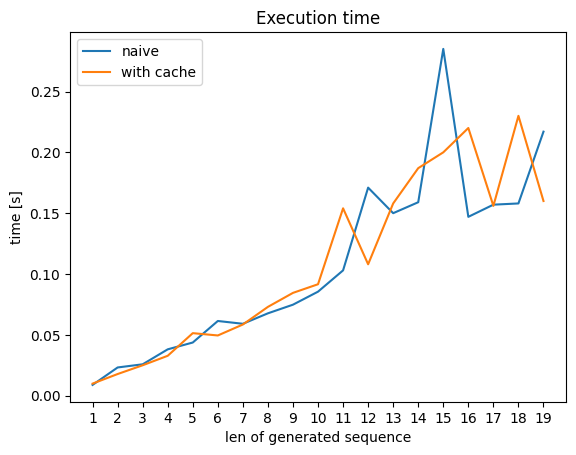

In [44]:
# execution time report

naive_time = []
cache_time = []
gen_len = [i for i in range(1, 20)]
batch = 3


for i in gen_len:
    input = torch.randint(0, VOCAB_SIZE, (batch, SEQ_LEN - i))
    cache_t = %timeit -o generate_with_cache(model, input, i)
    cache_time.append(str(cache_t).split(" ")[:2])
    naive_t = %timeit -o generate_naive(model, input, i)
    naive_time.append(str(naive_t).split(" ")[:2])


unit_dict = {"ns":10**(-9), "us":10**(-6), "ms":10**(-3), "s":1}
naive_time = [float(v)*unit_dict[unit] for v,unit in naive_time]
cache_time = [float(v)*unit_dict[unit] for v,unit in cache_time]


print(gen_len)
plt.plot(gen_len, naive_time, label="naive")
plt.plot(gen_len, cache_time, label="with cache")
plt.title('Execution time')
plt.legend()
plt.ylabel('time [s]')
plt.xlabel('len of generated sequence')
plt.xticks(gen_len)
plt.show()

## Implement Nucleus Sampling and Temperature (2p)
Sometimes using the greedy approach is not the best solution (for example model may fixate on a specific topic or start to repeat itself).  
One of the methods to alleviate this is to use nucleus sampling along with appropriate softmax temperature.  
Complete the code following the docstrings.

Trivially, if the input sequence is constant for the first $INITIAL$ terms, the whole resulting sequence should be constant.

See what happens when the input sequence is constant of different sizes greater than $INITIAL$, $top\_p$ is increased between $0$ and $1$ and the temperature has values below one, equal to one and greater than one. Describe the observations and a plausible reasoning for why. Write the answer below the code.

In [45]:
@torch.no_grad
def get_dist_after_with_temp_and_topp(
    model_logits: ModelLT, top_p: float, t: float
) -> ModelLT:
    """
    Allows to alter softmax temperature and sample using most probable elements that constitute to roughly top_p
    probability mass of the distribution.

    Given the output of the model before softmax (model_logits of shape [BATCH, SEQ, VOCAB_SIZE]),
    computes the softmax with temperature t (softmax(model_logits / t, dim=-1))
    to get the probability distribution prob (of shape [BATCH, SEQ, VOCAB_SIZE]) on the next token.
    Then for each b, s orders elements of prob[b, s] in non-ascending order
    and selects a prefix (pref[b, s])) of them such that the cummulative probability of sampling an element from this
    prefix is < top_p but after adding the next element it is >= top_p.
    Then it adds the next element to pref[b, s] (now the cummulative probability is >= top_p),
    sets the probability of remaining elements to 0.0, and rescales the probability distribution.
    The implementation is vectorized.
    """

    assert len(model_logits.shape) == 3
    ### YOUR CODE STARTS ###

    temp_softmax = F.softmax(model_logits/t,dim=-1)
    sorted_softmax, sorted_indices = torch.sort(temp_softmax, dim=-1, descending=True)

    cum_sum = torch.cumsum(sorted_softmax, dim=-1)

    nucleus = cum_sum < top_p
    nucleus =  torch.cat([nucleus.new_ones(nucleus.shape[:-1] + (1,)), nucleus[..., :-1]], dim=-1)
    sorted_softmax[~nucleus] = 0.0

    p_zeros = torch.zeros_like(temp_softmax)
    probs = p_zeros.scatter_add_(-1, sorted_indices, sorted_softmax)
    result = probs/torch.sum(probs, dim=-1, keepdim=True)

    ###  YOUR CODE ENDS  ###
    return result



@torch.no_grad
def token_choice_adv(model_logits: ModelLT, top_p: float, t: float) -> ModelLT:
    probs = get_dist_after_with_temp_and_topp(
        model_logits=model_logits[:, [-1], :], top_p=top_p, t=t
    )
    dist = torch.distributions.Categorical(probs=probs)
    return dist.sample()


##### TESTS START #####
@torch.no_grad
def test_nucleus():
    def test_dist_topp():
        # equal probs
        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 1.0, 1.0]]]), top_p=1.0, t=1.0
        )
        assert torch.abs(res - torch.tensor([1 / 3, 1 / 3, 1 / 3])).sum() <= 1e-4

        # non-equal probs

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[2.0, 3.0, 1.0]]]), top_p=0.0, t=1.0
        )
        assert torch.abs(res - torch.tensor([0.0, 1.0, 0.0])).sum() <= 1e-4

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[2.0, 3.0, 1.0]]]), top_p=0.6, t=1.0
        )
        assert torch.abs(res - torch.tensor([0.0, 1.0, 0.0])).sum() <= 1e-4

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 3.0, 2.0]]]), top_p=0.7, t=1.0
        )
        assert torch.abs(res - torch.tensor([0.0, 0.7311, 0.2689])).sum() <= 1e-2

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 3.0, 2.0]]]), top_p=1.0, t=1.0
        )
        assert torch.abs(res - torch.tensor([0.0900, 0.6652, 0.2447])).sum() <= 1e-2

    def test_temperature():
        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 1.0, 1.0]]]), top_p=1.0, t=3.0
        )
        assert torch.abs(res - torch.tensor([1 / 3, 1 / 3, 1 / 3])).sum() <= 1e-4

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 3.0, 2.0]]]), top_p=1.0, t=3.0
        )
        assert torch.abs(res - torch.tensor([0.2302, 0.4484, 0.3213])).sum() <= 1e-2

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 3.0, 2.0]]]), top_p=1.0, t=1 / 3
        )
        assert torch.abs(res - torch.tensor([0.0024, 0.9503, 0.0473])).sum() <= 1e-2

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 3.0, 2.0]]]), top_p=0.94, t=1 / 3
        )
        assert torch.abs(res - torch.tensor([0.0, 1.0, 0.0])).sum() <= 1e-4

    def test_batching():
        res = get_dist_after_with_temp_and_topp(
            torch.tensor(
                [[[1.0, 3.0, 2.0], [1.0, 4.0, 8.0]], [[8.0, 4.0, 1.0], [3.0, 1.0, 2.0]]]
            ),
            top_p=0.7,
            t=1.0,
        )
        assert (
            torch.abs(
                res
                - torch.tensor(
                    [
                        [[0.0, 0.7311, 0.2689], [0.0, 0.0, 1.0]],
                        [[1.0, 0.0, 0.0], [0.7311, 0.0, 0.2689]],
                    ]
                )
            ).sum()
            <= 1e-2
        )

    test_dist_topp()
    test_temperature()
    test_batching()

@torch.no_grad
def test_token_choice_adv(model):
    def test_equivalence():
        batch = 3
        for i in range(1, 20):
            input = torch.randint(0, VOCAB_SIZE, (batch, SEQ_LEN - i))
            output_naive_gen = generate_naive(
                model, input, i, token_choice=token_choice_greedy
            )
            output_cache_gen = generate_naive(
                model, input, i, functools.partial(token_choice_adv, top_p=0.0, t=1.0)
            )
            (output_naive_gen == output_cache_gen).to(torch.int32).sum() == batch * i

    test_equivalence()


test_nucleus()
test_token_choice_adv(model)
#####  TESTS END  #####

You can check responses of your model using the code below

In [46]:
input_data = torch.ones((1, SEQ_LEN-10), dtype=int) * 2
generate_with_cache(model=model, input=input_data, gen_length=SEQ_LEN - input_data.shape[-1], token_choice=functools.partial(token_choice_adv, top_p=0.5, t=0.1))

tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])

Trivially, if the input sequence is constant for the first $INITIAL$ terms, the whole resulting sequence should be constant.

See what happens when the input sequence is constant of different sizes greater than $INITIAL$, $top\_p$ is increased between $0$ and $1$ and the temperature has values below one, equal to one and greater than one. Describe the observations and a plausible reasoning for why. Write the answer below the code.

In [47]:
# testing different sizes of the seq

print('TESTING DIFFERENT SIZES OF INPUT SEQUENCE')
t=0.1
p=0.5
print(f'for t={t} and p={p}'+"-"*30)
for i in range(11):
    input_data = torch.ones((1, SEQ_LEN-10+i), dtype=int) * 2
    print(f'for input sequence of len {SEQ_LEN-10+i}, top_p={p}, t={t}')
    print(generate_with_cache(model=model, input=input_data, gen_length=10, token_choice=functools.partial(token_choice_adv, top_p=p, t=t)))

t=0.1
p=0.2
print(f'for t={t} and p={p}'+"-"*30)
for i in range(11):
    input_data = torch.ones((1, SEQ_LEN-10+i), dtype=int) * 2
    print(f'for input sequence of len {SEQ_LEN-10+i}, top_p={p}, t={t}')
    print(generate_with_cache(model=model, input=input_data, gen_length=10, token_choice=functools.partial(token_choice_adv, top_p=p, t=t)))
print("="*50)

t=0.1
p=0.7
print(f'for t={t} and p={p}'+"-"*30)
for i in range(11):
    input_data = torch.ones((1, SEQ_LEN-10+i), dtype=int) * 2
    print(f'for input sequence of len {SEQ_LEN-10+i}, top_p={p}, t={t}')
    print(generate_with_cache(model=model, input=input_data, gen_length=10, token_choice=functools.partial(token_choice_adv, top_p=p, t=t)))
print("="*50)

t=0.1
p=1
print(f'for t={t} and p={p}'+"-"*30)
for i in range(11):
    input_data = torch.ones((1, SEQ_LEN-10+i), dtype=int) * 2
    print(f'for input sequence of len {SEQ_LEN-10+i}, top_p={p}, t={t}')
    print(generate_with_cache(model=model, input=input_data, gen_length=10, token_choice=functools.partial(token_choice_adv, top_p=p, t=t)))

t=1
p=0.5
print(f'for t={t} and p={p}'+"-"*30)
for i in range(11):
    input_data = torch.ones((1, SEQ_LEN-10+i), dtype=int) * 2
    print(f'for input sequence of len {SEQ_LEN-10+i}, top_p={p}, t={t}')
    print(generate_with_cache(model=model, input=input_data, gen_length=10, token_choice=functools.partial(token_choice_adv, top_p=p, t=t)))

t=1
p=0.5
print(f'for t={t} and p={p}'+"-"*30)
for i in range(11):
    input_data = torch.ones((1, SEQ_LEN-10+i), dtype=int) * 2
    print(f'for input sequence of len {SEQ_LEN-10+i}, top_p={p}, t={t}')
    print(generate_with_cache(model=model, input=input_data, gen_length=10, token_choice=functools.partial(token_choice_adv, top_p=p, t=t)))

t=1.5
p=0.5
print(f'for t={t} and p={p}'+"-"*30)
for i in range(11):
    input_data = torch.ones((1, SEQ_LEN-10+i), dtype=int) * 2
    print(f'for input sequence of len {SEQ_LEN-10+i}, top_p={p}, t={t}')
    print(generate_with_cache(model=model, input=input_data, gen_length=10, token_choice=functools.partial(token_choice_adv, top_p=p, t=t)))

print("="*50)



TESTING DIFFERENT SIZES OF INPUT SEQUENCE
for t=0.1 and p=0.5------------------------------
for input sequence of len 54, top_p=0.5, t=0.1
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
for input sequence of len 55, top_p=0.5, t=0.1
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
for input sequence of len 56, top_p=0.5, t=0.1
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
for input sequence of len 57, top_p=0.5, t=0.1
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
for input sequence of len 58, top_p=0.5, t=0.1
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
for input sequence of len 59, top_p=0.5, t=0.1
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
for input sequence of len 60, top_p=0.5, t=0.1
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
for input sequence of len 61, top_p=0.5, t=0.1
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
for input sequence of len 62, top_p=0.5, t=0.1
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
for input sequence of len 63, top_p=0.5, t=0.1
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
for input sequence of len 64

In [48]:
# testing different top_p

print("TESTING DIFFERENT top_p")
print("INPUT: ")
print(input_data)

t=0.1
print(f'for t={t}'+"-"*30)
input_data = torch.ones((1, SEQ_LEN-10), dtype=int) * 2
for p in torch.arange(0,1,0.05):
    input_data = torch.ones((1, SEQ_LEN-10), dtype=int) * 2
    print(f'for input sequence of len {SEQ_LEN-10}, top_p={p}, t={t}')
    print(generate_with_cache(model=model, input=input_data, gen_length=SEQ_LEN - input_data.shape[-1], token_choice=functools.partial(token_choice_adv, top_p=p, t=t)))

t=1
print(f'for t={t}'+"-"*30)
input_data = torch.ones((1, SEQ_LEN-10), dtype=int) * 2
for p in torch.arange(0,1,0.05):
    input_data = torch.ones((1, SEQ_LEN-10), dtype=int) * 2
    print(f'for input sequence of len {SEQ_LEN-10}, top_p={p}, t={t}')
    print(generate_with_cache(model=model, input=input_data, gen_length=SEQ_LEN - input_data.shape[-1], token_choice=functools.partial(token_choice_adv, top_p=p, t=t)))

t=1.5
print(f'for t={t}'+"-"*30)
input_data = torch.ones((1, SEQ_LEN-10), dtype=int) * 2
for p in torch.arange(0,1,0.05):
    input_data = torch.ones((1, SEQ_LEN-10), dtype=int) * 2
    print(f'for input sequence of len {SEQ_LEN-10}, top_p={p}, t={t}')
    print(generate_with_cache(model=model, input=input_data, gen_length=SEQ_LEN - input_data.shape[-1], token_choice=functools.partial(token_choice_adv, top_p=p, t=t)))
print("="*50)

TESTING DIFFERENT top_p
INPUT: 
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
for t=0.1------------------------------
for input sequence of len 54, top_p=0.0, t=0.1
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
for input sequence of len 54, top_p=0.05000000074505806, t=0.1
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
for input sequence of len 54, top_p=0.10000000149011612, t=0.1
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
for input sequence of len 54, top_p=0.15000000596046448, t=0.1
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
for input sequence of len 54, top_p=0.20000000298023224, t=0.1
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
for input sequence of len 54, top_p=0.25, t=0.1
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
for input sequence of len 54, top_p=0.30000001192092896, t=0.1
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
for input 

In [49]:
# testing different temp

print("TESTING DIFFERENT TEMP")
input_data = torch.ones((1, SEQ_LEN-10), dtype=int) * 2
print("INPUT: ")
print(input_data)

p=0.2
print(f'for p={p}'+"-"*30)
for t in torch.arange(0.1,2,0.1):
    print(f'for input sequence of len {SEQ_LEN-10}, top_p=0.5, t={t}')
    print(generate_with_cache(model=model, input=input_data, gen_length=SEQ_LEN - input_data.shape[-1], token_choice=functools.partial(token_choice_adv, top_p=0.5, t=t)))

p=0.5
print(f'for p={p}'+"-"*30)
for t in torch.arange(0.1,2,0.1):
    print(f'for input sequence of len {SEQ_LEN-10}, top_p=0.5, t={t}')
    print(generate_with_cache(model=model, input=input_data, gen_length=SEQ_LEN - input_data.shape[-1], token_choice=functools.partial(token_choice_adv, top_p=0.5, t=t)))

p=0.7
print(f'for p={p}'+"-"*30)
for t in torch.arange(0.1,2,0.1):
    print(f'for input sequence of len {SEQ_LEN-10}, top_p=0.5, t={t}')
    print(generate_with_cache(model=model, input=input_data, gen_length=SEQ_LEN - input_data.shape[-1], token_choice=functools.partial(token_choice_adv, top_p=0.5, t=t)))

p=1.0
print(f'for p={p}'+"-"*30)
for t in torch.arange(0.1,2,0.1):
    print(f'for input sequence of len {SEQ_LEN-10}, top_p=0.5, t={t}')
    print(generate_with_cache(model=model, input=input_data, gen_length=SEQ_LEN - input_data.shape[-1], token_choice=functools.partial(token_choice_adv, top_p=0.5, t=t)))
print("="*50)

TESTING DIFFERENT TEMP
INPUT: 
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2]])
for p=0.2------------------------------
for input sequence of len 54, top_p=0.5, t=0.10000000149011612
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
for input sequence of len 54, top_p=0.5, t=0.20000000298023224
tensor([[2, 2, 2, 2, 2, 3, 3, 3, 3, 3]])
for input sequence of len 54, top_p=0.5, t=0.30000001192092896
tensor([[2, 3, 3, 3, 3, 3, 3, 3, 3, 3]])
for input sequence of len 54, top_p=0.5, t=0.4000000059604645
tensor([[2, 2, 3, 3, 3, 3, 3, 3, 3, 3]])
for input sequence of len 54, top_p=0.5, t=0.5
tensor([[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])
for input sequence of len 54, top_p=0.5, t=0.6000000238418579
tensor([[1, 2, 2, 1, 2, 3, 2, 2, 3, 2]])
for input sequence of len 54, top_p=0.5, t=0.699999988079071
tensor([[1, 2, 2, 5, 0, 3, 4, 0, 1, 2]])
for input sequence of len 54, 

## Observations

Elongating given constant input sequence doesn't change the result for p=0.5 and t=0.1 (it is always a constant sequence of a given token from the input) (though it is worth noting, that for different top_p and t it is not always the case: when the top_p=1 sequences are not constant, and when temperature is higher it is also the case).

Increasing top_p from 0 to 1: with the increase of top_p parameter, the resulting sequence stops being constant sequence of a given token from the input (especially when p is getting close to 1, and when the temperature is higher it can be seen earlier).

When the temperature gets closer to 0, the generated sequences are less diverse and are more likely to stay constant. With the increase of T, result is more random.

## Possible explanation

When T is larger the probabilities that we get after scaling by t are less divergent from each other - there will be more diversity in generated sequence - more randomness (the resulting probabilities will be higher for low probability states than initially). When T is getting closer to 0, there is less randomness and the most likely state is even more likely in the resulting distibution.

With the increase of top_p parameter, it is more likely than tokens with low probability will have to be included to exceed the threshold, so then unlikely tokens have a chance to appear in output sequence in a contrast to low top_p, when usually a few or one most probable token will be enough.

It could be expected, that with the increase in input seq len, the output is more resistant (result stays the constant sequence) to too high temperature and top_p parameter. It is difficult to see without closer egzamination and is not clearly visible in given examples.

# Additional Evaluation
Following tasks consider additional evaluation of your model. Describe what you are able to observe on the plots and give a plausable reasoning why below the task.

## Per Token Accuracy (1p)
Calculate the per-token accuracy of you model. That is for each position $\{0, \dots, SEQ\_LEN\ - 1\}$ in the input calculate average accuracy across the test set for the prediction of the next token.  
Plot the results.

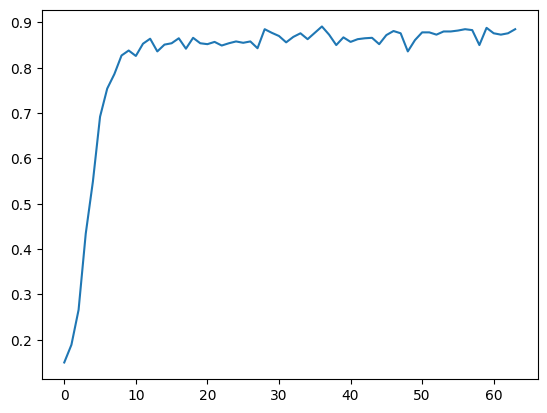

In [72]:
import matplotlib.pyplot as plt
@torch.no_grad
def calc_per_token_acc(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader):
    ### YOUR CODE STARTS ###
    model.eval()
    sum_acc = torch.zeros(SEQ_LEN).to(DEVICE)
    num_examples = 0

    for x,y in data_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        model_out,_ = model(x)
        # print(model_out.shape)
        # print(torch.argmax(model_out, dim=-1).shape)
        acc = (torch.argmax(model_out, dim=-1) == y).to(torch.float32)
        sum_acc += acc.sum(dim=0)
        num_examples += model_out.shape[0]

    per_token_acc = sum_acc/num_examples


    ###  YOUR CODE ENDS  ###
    return per_token_acc.cpu()


per_token_acc = calc_per_token_acc(model, TEST_LOADER)
plt.plot(np.arange(per_token_acc.shape[0]), per_token_acc)
plt.show()

For the first few positions accuracy increases rapidly and then stays in the range 0.8-0.9. Longer prefix allows model for more accurate token prediction, as it gives more information about the contex (but only to some extend - posistions that are far enough are usually not relevant anymore, so having couple of positions in the back is enough to get decent accuracy that stays more or less the same for the rest of the positions).